##Pip

In [ ]:
!pip install pykalman bottleneck

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 13.6 MB/s eta 0:00:00
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48442 sha256=e56732351b51658e8f94a23253f3c32dd2b7dd40a70df1d76c1f4d83b92c638d
  Stored in directory: /root/.cache/pip/wheels/76/33/ef/5f332226e13a5089c6dd4b01cc2bcb59491d18f955fa2d3807
Successfully built pykalman


##Package

In [ ]:
import dateutil.parser
import time
import pickle
import random
import numpy as np
import pandas as pd
import bottleneck as bn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from numpy import ma
from pykalman import KalmanFilter
from scipy import fftpack

In [ ]:
filename = 'ctg_2081'
filepath = f'/content/drive/MyDrive/Colab Notebooks/{filename}.csv'

##Data loading
load ctg data

In [ ]:
info = pd.read_csv(
        filepath,
        header=None,
        skiprows=1,
        nrows=1,
        index_col=False,
        dtype='unicode').loc[0, :]

info.index = ['BedName', 'REC st', 'REC ed', 'REC time', 'weeks', 'PT id']

info['filename'] = filename

In [ ]:
#example
info

0                   LDR8
1    2021/08/04 14:52:42
2    2021/08/05 01:48:15
3                  39334
4                    NaN
5           000000152766
Name: 0, dtype: object

In [ ]:
df = pd.read_csv(filepath, skiprows=2, index_col=False, usecols = ['FHR1', 'MHR', 'UA'],
                      dtype={
                             'FHR1': 'int64',
                             'MHR': 'int64',
                             'UA': 'int64',
                             })

print(df)

        FHR1  MHR  UA
0         -1    0  20
1         -1    0  20
2         -1    0  20
3         -1    0  20
4         -1    0  20
...      ...  ...  ..
157331     0   -1  -1
157332     0   -1  -1
157333     0   -1  -1
157334     0   -1  -1
157335     0   -1  -1

[157336 rows x 3 columns]


##Pre process

###Function / Class

In [ ]:
class FFTFilter(object):
    def __init__(self, dat, sampling_freq, ):
        self.sampling_freq = np.array(sampling_freq)
        _y = dat.values[:]
        _n = len(_y)
        _dt = 1 / sampling_freq  # サンプリング間隔

        self.yf = fftpack.rfft(_y) / (_n / 2)
        self.freq = fftpack.fftfreq(_n, _dt)

    def filter(self, cutoff_freq_low=0.04, cutoff_freq_high=0.4, norm=0):
        _yf2 = np.copy(self.yf)
        _n = len(_yf2)
        _yf2[(self.freq < cutoff_freq_low)] = 0
        _yf2[(self.freq > cutoff_freq_high)] = 0
        _yf2[(self.freq < 0)] = 0
        _y2 = np.real(fftpack.irfft(_yf2) * (_n / 2))

        # normalization
        if norm > 0:
            _y2 = _y2 / np.max(_y2) * norm

        return pd.Series(_y2)

def get_sampling_freq(dat_, df):
    rec_st = dateutil.parser.parse(dat_['REC st'])
    rec_ed = dateutil.parser.parse(dat_['REC ed'])
    rec_term = (rec_ed - rec_st).total_seconds() + 1  # noqa F841
    sel_time = np.int64(dat_['REC time'])
    data_size = len(df.index)  # ctg data size
    sampling_freq = int(data_size / sel_time + 0.1)  # Sampling freq
    return sampling_freq

###Content

In [ ]:
#data2 = pre.pre_process_data(
#    raw_data,
#    update_fftdata_flg_=conf.P_FORCE_UPDATE_FFT_DATA)

    # - fill NA
    # - Kalman Filter
    # - FFT Filter


# MHR

#fill NA in MHR
##pd.DataFrame.interpolate?
df['MHR'] = df['MHR'].replace(0, np.nan)
df['MHR'] = df['MHR'].replace(-1, np.nan)
df['edited_MHR'] = df['MHR'].interpolate(
    method="linear",
    limit_area="outside",
    limit_direction="both")

#cut outlier in MHR
df['edited_MHR'] = df['edited_MHR'].where((df['edited_MHR'] > 50) & (df['edited_MHR'] < 200))

#cut too short trace in MHR
##int = 5 * 4 * 0 => Is this part skipped?

# Kalman filter
## skip

# FHR

#fill NA in FHR
df['FHR1'] = df['FHR1'].replace(0, np.nan)
df['FHR1'] = df['FHR1'].replace(-1, np.nan)
df['edited_FHR1'] = df['FHR1'].interpolate(
    method="linear",
    limit_area="outside",
    limit_direction="both")

# delete similar tracing to MHR
## skip

#cut outlier in FHR
df['edited_FHR1'] = df['edited_FHR1'].where((df['edited_FHR1'] > 50) & (df['edited_FHR1'] < 200))

#cut too short trace in FHR
#    fhr1_cut_too_short = util.cut_too_short_ser(
#        fhr1_cut_outlier, conf.P_CUTOFF_LEN)
##int = 5 * 4 * 0 => Is this part skipped?

#rate of NaN
## skip

# Kalman filter(60sec)
val = ma.asarray(df['edited_FHR1'].values)
val = ma.where(np.isnan(val), ma.masked, val) #fill NaN
kf = KalmanFilter(transition_matrices=np.array([[1, 1], [0, 1]]),
                  transition_covariance=0.0001 * np.eye(2)).em(val, n_iter=5)  # np.eyeは単位行列
smoothed = kf.smooth(val)[0] #6sec
filtered = kf.filter(val)[0]

df['filtered_FHR1'] = df['edited_FHR1'].where(df['edited_FHR1'].isna(), smoothed[:, 0]).fillna(pd.Series(filtered[:, 0]))

#mask by outlier in FHR
#skip

# FFT fileter
sampling_freq = get_sampling_freq(info, df)
fhr1_fft_filter = FFTFilter(df['filtered_FHR1'], sampling_freq)

df["FHR1_lowpass0010"] = fhr1_fft_filter.filter(0.0000, 0.0100)
df["FHR1_lowpass0100"] = fhr1_fft_filter.filter(0.0000, 0.1000)
df["FHR1_filtered_VLF"] = fhr1_fft_filter.filter(0.0033, 0.0400)
df["FHR1_filtered_LF"] = fhr1_fft_filter.filter(0.0400, 0.1500)
df["FHR1_filtered_HF"] = fhr1_fft_filter.filter(0.1500, 0.4000)
del fhr1_fft_filter



df.describe()

FHR1            MHR             UA     edited_MHR  \
count  145973.000000  147152.000000  157336.000000  147589.000000   
mean      136.719421      75.891887      26.115492      75.893488   
std        18.389894      14.431689      14.178577      14.420203   
min        50.000000      40.000000      -1.000000      52.000000   
25%       123.000000      67.000000      17.000000      67.000000   
50%       138.000000      73.000000      25.000000      73.000000   
75%       147.000000      79.000000      33.000000      79.000000   
max       240.000000     148.000000     109.000000     148.000000   

         edited_FHR1  filtered_FHR1  FHR1_lowpass0010  FHR1_lowpass0100  \
count  153058.000000  157336.000000     157336.000000     157336.000000   
mean      135.350096     133.707167        133.707167        133.707167   
std        17.500152      26.167130         23.713798         25.971122   
min        58.000000    -381.492563       -179.362394       -387.259661   
25%       120.000000     119.063019        121.138460        119.190978   
50%       137.000000     136.283231        136.203823        136.271782   
75%       146.000000     146.144371        145.525608        146.179722   
max       194.000000     208.985718        184.544934        194.212935   

       FHR1_filtered_VLF  FHR1_filtered_LF  FHR1_filtered_HF  
count       1.573360e+05      1.573360e+05      1.573360e+05  
mean       -6.936706e-17      8.083792e-18      1.428212e-18  
std         1.575176e+01      4.922277e+00      2.024087e+00  
min        -3.453588e+02     -1.621250e+02     -1.289655e+02  
25%        -2.689664e+00     -1.131391e+00     -2.482566e-01  
50%        -2.387557e-02     -2.316085e-02     -6.641504e-04  
75%         2.684816e+00      1.117880e+00      2.472091e-01  
max         1.535132e+02      1.452238e+02      1.301482e+02

###Pickle

In [ ]:
with open(f'/content/drive/MyDrive/Colab Notebooks/{filename}_processed.pickle', mode='wb') as f:
    pickle.dump(df, f)

In [ ]:
with open(f'/content/drive/MyDrive/Colab Notebooks/{filename}_processed.pickle', mode='rb') as f:
    df = pickle.load(f)

##Draw baseline

###Function / Class

In [ ]:
#16sec -> 0sec

def move_std(ser_, window_=1):
    if len(ser_) < window_:
        return pd.Series([np.nan] * len(ser_))
    return pd.Series(bn.move_std(ser_, window=window_, min_count=None)[window_//2:], dtype='float64')

def cutoff_mask(dat_, th_low=0, th_upr_=0):
    mask = ((th_low == 0 or dat_ >= th_low) & (th_upr_ == 0 or dat_ <= th_upr_)).replace(False, np.nan)
    mask[dat_.isna()] = np.nan
    return mask.astype('float64')

def calc_move_std_mask(dat_, term_,
                       th_min_=0,
                       th_max_=15):
    """移動標準偏差によるマスク"""
    variability_ = move_std(dat_, term_).interpolate(
        method="linear",
        limit_area="outside",
        limit_direction="both")
    mask_ = cutoff_mask(variability_, th_min_, th_max_)
    return mask_, variability_

def moving_average(dat_, window_=5):
    return dat_.rolling(window=window_, center=True).mean()

def gradient(dat_, dx_=1):
    return pd.Series(np.gradient(dat_.values, dx_))

def calc_moving_average_mask(dat_, term_=120,
                             th_min_=-0.05,
                             th_max_=0.05):
    """移動平均の傾きによるマスク"""
    moving_average_ = moving_average(dat_, term_)
    gradient_ = gradient(moving_average_)

    mask_ = cutoff_mask(gradient_, th_min_, th_max_)
    return mask_, moving_average_, gradient_

def cut_too_short(dat_, len_):

    # 一つもNanが無い
    if (not dat_.isnull().any()):
        return dat_[:]

    dat0 = pd.Series(
        np.append(
            np.insert(
                dat_.values,
                0,
                np.nan),
            np.nan))
    indexes = dat0[dat0.isnull()].index
    ret_: list = []

    for i, x in enumerate(indexes[:-1]):

        j = indexes[i + 1] - indexes[i] - 1
        ret_ = np.hstack([ret_, np.nan])

        if j <= 0:
            pass
        elif j < len_:
            ret_ = np.hstack([ret_, np.full(j, np.nan)])
        else:
            ret_ = np.hstack([ret_, np.ones(j)])

    return ret_[1:]

def cut_too_short_ser(dat_, len_):
    return pd.Series(dat_.values * cut_too_short(dat_, len_))

###Content

In [ ]:
df['mask1'], df["FHR1_variability"] =calc_move_std_mask(df['filtered_FHR1'], 4 * 10, 0, 15)

df['mask2'], df["FHR1_move_mean"], df["FHR1_move_mean_gradient"] =\
    calc_moving_average_mask(df['filtered_FHR1'], 4 * 45, -0.05, 0.05)

In [ ]:
df['mask'] = cut_too_short_ser(df['mask1'] * df['mask2'], 20 * 4)

df["FHR1_baseline_low_variability"] =\
        (df["FHR1_move_mean"] * df['mask']).interpolate(
        method="linear",
        limit_area=None,
        limit_direction="both")

df[['mask', 'mask1', 'mask2']].describe()

mask     mask1     mask2
count  114021.0  156394.0  125289.0
mean        1.0       1.0       1.0
std         0.0       0.0       0.0
min         1.0       1.0       1.0
25%         1.0       1.0       1.0
50%         1.0       1.0       1.0
75%         1.0       1.0       1.0
max         1.0       1.0       1.0

In [ ]:
df.describe()

FHR1           MHR            UA    edited_MHR   edited_FHR1  \
count  19175.000000  17600.000000  22408.000000  17879.000000  19870.000000   
mean     133.241147     93.206534     63.421591     93.665082    132.407146   
std       17.528169     10.323420     25.395691     11.105149     18.123244   
min       49.000000     66.000000      0.000000     66.000000     52.000000   
25%      130.000000     87.000000     45.000000     87.000000    129.000000   
50%      137.000000     94.000000     59.000000     95.000000    136.000000   
75%      142.000000    100.000000     76.000000    101.000000    142.000000   
max      164.000000    161.000000    127.000000    161.000000    164.000000   

       filtered_FHR1  FHR1_lowpass0010  FHR1_lowpass0100  FHR1_filtered_VLF  \
count   22408.000000      22408.000000      22408.000000       2.240800e+04   
mean      128.425590        128.425590        128.425590      -1.608852e-15   
std        26.468754         23.995423         26.216496       1.745550e+01   
min       -46.579014          8.909887        -43.173458      -1.195137e+02   
25%       127.737021        128.009462        127.808312      -4.540295e+00   
50%       135.641022        136.431896        135.608185      -5.413039e-01   
75%       141.495235        141.983815        141.607255       5.260424e+00   
max       214.553732        154.598934        215.330175       1.192265e+02   

       FHR1_filtered_LF  FHR1_filtered_HF    mask1    mask2  FHR1_move_mean  \
count      2.240800e+04      2.240800e+04  22001.0  15616.0    22229.000000   
mean      -2.271181e-17      5.079439e-17      1.0      1.0      128.617138   
std        5.489926e+00      2.288856e+00      0.0      0.0       24.568464   
min       -4.492752e+01     -3.584512e+01      1.0      1.0      -15.422920   
25%       -1.992726e+00     -3.961712e-01      1.0      1.0      128.179609   
50%        8.381325e-02      2.433368e-03      1.0      1.0      136.652420   
75%        1.963450e+00      4.021005e-01      1.0      1.0      141.699492   
max        5.192138e+01      3.985710e+01      1.0      1.0      184.460020   

       FHR1_move_mean_gradient     mask  FHR1_baseline_low_variability  
count             22227.000000  14081.0                   22408.000000  
mean                 -0.001874      1.0                     127.573587  
std                   0.122343      0.0                      21.657859  
min                  -0.863850      1.0                      57.413637  
25%                  -0.026327      1.0                     126.988143  
50%                   0.000408      1.0                     134.695037  
75%                   0.025910      1.0                     140.653226  
max                   0.772615      1.0                     151.558005

##Detect Decerelation

In [ ]:
#    train_initial_sect_series = None
#    if conf.P_CREATE_INIT_ANNOT_DATA or True:
#        train_initial_sect_series =\
#            mk.make_train_initial_sect_series(data2, save_flg=True)

#data2 : all patients data

###Function / Class

In [ ]:
def is_valid_nan_ratio(ser_, rat_min_=0.0, rat_max_=1.0):
    ser = pd.Series(ser_)
    rat_min = float(rat_min_)
    rat_max = float(rat_max_)
    return float(ser.isnull().sum()) >= float(rat_min * ser.count()) and\
        float(ser.isnull().sum()) <= float(rat_max * ser.count())

###Content

In [ ]:
ref_id0="FHR1_lowpass0100"
ref_id1="FHR1_lowpass0100"
base_id="FHR1_baseline_low_variability"
#base_id="FHR1_baseline_low_variability"
refer_nan_label_="FHR1_cutoff_mask"
th0=0 #conf.P_SECTION_FIND_TH_MIN
th1=1 #conf.P_SECTION_FIND_TH_MAX
kind=1

time_sta = time.time()
freq = get_sampling_freq(info, df)
xFactor_ = pd.Series(1 / (0.5 * df["FHR1_variability"].values))  # 補正係数
diff0_ = ((df[ref_id0] - df[base_id]) * xFactor_).values  # 偏差
diff1_ = ((df[ref_id1] - df[base_id]) * xFactor_).values  # 偏差
#mask_ = df["FHR1_cutoff_mask"]  # 外れ値と細変動、Nan比率によるマスク

cntNorm, cntOutlier, cnt2Short, cnt2Long, cnt2ManyNan, cntZerox = 0, 0, 0, 0, 0, 0

annot_arr = []
st0 = None
st = None
for i in range(np.size(diff0_)):

    if st0 is None and st is None and\
            diff0_[i] <= -th0:
        # start of decel
        st0 = i

    if st0 is not None and st is None and\
            diff1_[i] <= -th1:
        # reach threshold of decel
        st = st0

    if st is not None and\
            diff0_[i] >= -th0:
        ed = i
        dict_ = {
            "no": np.size(annot_arr) + 1,
            "st": st,
            "ed": ed,
            "ct": (st + ed) // 2,
            "cls": 1,
            # "cls0": None,
            "kind": kind,
        }

        if (ed - st) < (20 * 4): #P_SHAPE_CUTOFF_WIDTH_MIN
            # print("too short section!!!")
            cnt2Short += 1
            st0 = None
            st = None
            continue

        if (ed - st) > (180 * 4): #conf.P_SHAPE_CUTOFF_WIDTH_MAX
            # print("too long section!!!")
            cnt2Long += 1
            st0 = None
            st = None
            continue

#        if not is_valid_nan_ratio(ctgd[refer_nan_label_][st:ed],
#                                      0.0, #P_ACCEPT_CNN_NAN_RATIO_MIN
#                                      0.0001): #P_ACCEPT_CNN_NAN_RATIO_MAX
            # print("Nan ratio is invalid!!!")
#            cnt2ManyNan += 1
#            st0 = None
#            st = None
#            continue

#        if np.isnan(mask_[i]):
            # print("outlier value!!!")
#            cntOutlier += 1
#            st0 = None
#            st = None
#            continue

        st0 = None
        st = None
        annot_arr.append(dict_)
        cntNorm += 1  # Normal

    if ((i > 0 and diff0_[i - 1] >= 0 and diff0_[i] <= 0) or
            (i > 0 and diff0_[i - 1] <= 0 and diff0_[i] >= 0)):
        # print("reset by zero crossing")
        cntZerox += 1
        st0 = None
        st = None

data = dict()

data['FHR1_annotated'] = annot_arr

<ipython-input-14-a8d72d2efa69>:11: RuntimeWarning: divide by zero encountered in true_divide
  xFactor_ = pd.Series(1 / (0.5 * df["FHR1_variability"].values))  # 補正係数


##Plot CTG trace

###Function / Class

###Content

In [ ]:
lbl_lst = [
    'FHR1_lowpass0100',
    'FHR1_baseline_low_variability',
    'filtered_FHR1',
]

lbl_lst2 = [
    'FHR1',
    'MHR',
    'UA',
]

sect_lst_ = data['FHR1_annotated']

ROWS_OF_PAGE = 8

fig_id = info['filename']
freq = get_sampling_freq(info, df)
x_width_one = 1200 * freq

data_len = max(len(df.index), x_width_one * 2)  # data length
fig_all_rows = (data_len + x_width_one - 1) // x_width_one

pages = -(-fig_all_rows // ROWS_OF_PAGE)

for p in range(pages):
    (p_from, p_to) = (p * ROWS_OF_PAGE, min((p + 1) * ROWS_OF_PAGE, fig_all_rows))

    if p_from + 1 == p_to:
        p_to += 1  # 1行になるとエラーになるので。
    if pages == 1:
        fig_filename = "{}".format(fig_id)
    else:
        fig_filename = "{}({}of{})".format(fig_id, str(p + 1), pages)
    
    fig_rows = p_to - p_from
    fig_height = 7 * fig_rows
    x_max = x_width_one * fig_rows
    x_max_width = x_max // freq
    x_width = x_max_width // fig_rows

    fig, axes = plt.subplots(fig_rows, 1, figsize=(40, fig_height))
    fig.subplots_adjust(hspace=1.0, wspace=0.4)
    fig.suptitle(fig_filename, size=30, color="blue")
    fig.patch.set_facecolor('white')

    color_list = [
        '#377eb8', '#984ea3', '#ff7f00', '#4daf4a',
        '#a65628', '#e41a1c', 'g', 'b', 'c', 'm',
        '#a65628', '#f781bf', '#f781bf',
    ]

    color_list = color_list * 3
    random.seed(1)

    fhr = df['filtered_FHR1'].values
    uc = df['UA'].values

    for i in range(p_from, p_to):
        ii = i - p_from

        for j, lbl in enumerate(lbl_lst):
            axes[ii].plot(
                df[lbl].index / freq,
                df[lbl].values,
                label=lbl,
                color=cm.tab20(
                    (j * 3 + 5) % 20
                ),
                lw=1,
                ls="-."
            )
        
        for j, lbl in enumerate(lbl_lst2):
            axes[ii].plot(
                df[lbl].index / freq,
                df[lbl].values,
                label=lbl,
                color=cm.tab20(
                    j *
                    1 %
                    20
                ),
                lw=1.2
            )
        axes[ii].grid(which='both')
        axes[ii].set_ylim(-100, 250)
        axes[ii].set_xticks(
            np.linspace(
                x_width * i, x_width * (i + 1), 20 + 1
            ), minor=False
        )
        axes[ii].set_xticks(
            np.linspace(
                x_width * i, x_width * (i + 1), 120 + 1
            ), minor=True
        )
        axes[ii].set_xlim(x_width * i, x_width * (i + 1))
        axes[ii].xaxis.set_tick_params(rotation=90)
        axes[ii].axhline(y=160, color='r', ls='--', lw=0.4)
        axes[ii].axhline(y=110, color='r', ls='--', lw=0.4)
        axes[ii].legend()

    #pred_lst was not defined

        s = 0

        for p, dict_ in enumerate(sect_lst_):
            kind = 0
            if 'kind' in dict_.keys():
                kind = int(dict_['kind'])
            color_ = "g"
            if 'cls0' in dict_ and dict_['cls0'] is not None:
                cls = int(dict_['cls0'])
                color_ = ["g", "b", "r", "c", "m"][cls]
            linestyle_ = ["-.", "--", ":", "-"][s]
            x_st = dict_['st']
            x_ed = dict_['ed']
            if x_st >= x_ed:
                continue
            y_min = -90 + s * 40
            y_max = np.minimum(
                np.max(fhr[x_st:x_ed]) + 20 + (p % 2 * 15), 220
            )

            xy = (x_st / freq, y_min)
            w = (x_ed - x_st) / freq
            h = y_max - y_min
            rect = patch.Rectangle(
                xy=xy,
                width=w,
                fill=False,
                height=h,
                edgecolor=color_,
                linewidth=3,
                linestyle=linestyle_
            )
            axes[ii].add_patch(rect)

            p_x = dict_['ct']
            if 'cls0' in dict_:
                cls = dict_['cls0']
                axes[ii].plot(
                    p_x / freq + 12,
                    y_min + 12,
                    marker="$" + str(int(cls)) + "$",
                    markersize=12,
                    color=color_
                )
            if 'cls' in dict_:
                p_x = dict_['ct']
                cls = dict_['cls']
                axes[ii].plot(
                    p_x / freq - 12,
                    y_min + 12,
                    marker="$" + str(int(cls)) + "$",
                    markersize=12,
                    color=color_
                )
            if 'no' in dict_:
                num = dict_['no']
                ct_y = y_min + 12
                cir = patch.Ellipse(
                    (p_x / freq, ct_y),
                    width=12,
                    height=20,
                    edgecolor=color_,
                    linewidth=3,
                    fill=False
                )
                axes[ii].add_patch(cir)
                axes[ii].plot(
                    p_x / freq,
                    ct_y,
                    marker="$" + str(int(num)) + "$",
                    markersize=18,
                    color=color_
                )
    
    plt.tight_layout()
    plt.show()
    plt.close()

Output hidden; open in https://colab.research.google.com to view.

###Simple plotter

In [ ]:
filename = 'ctg_0964-3'

df = pd.read_csv(f'/content/drive/MyDrive/2023_04/{filename}.csv')
info = pd.read_csv(f'/content/drive/MyDrive/2023_04/info_{filename}.csv')

In [ ]:
#example
info.iloc[0].to_dict()['REC st']

'2016/10/03 11:54:38'

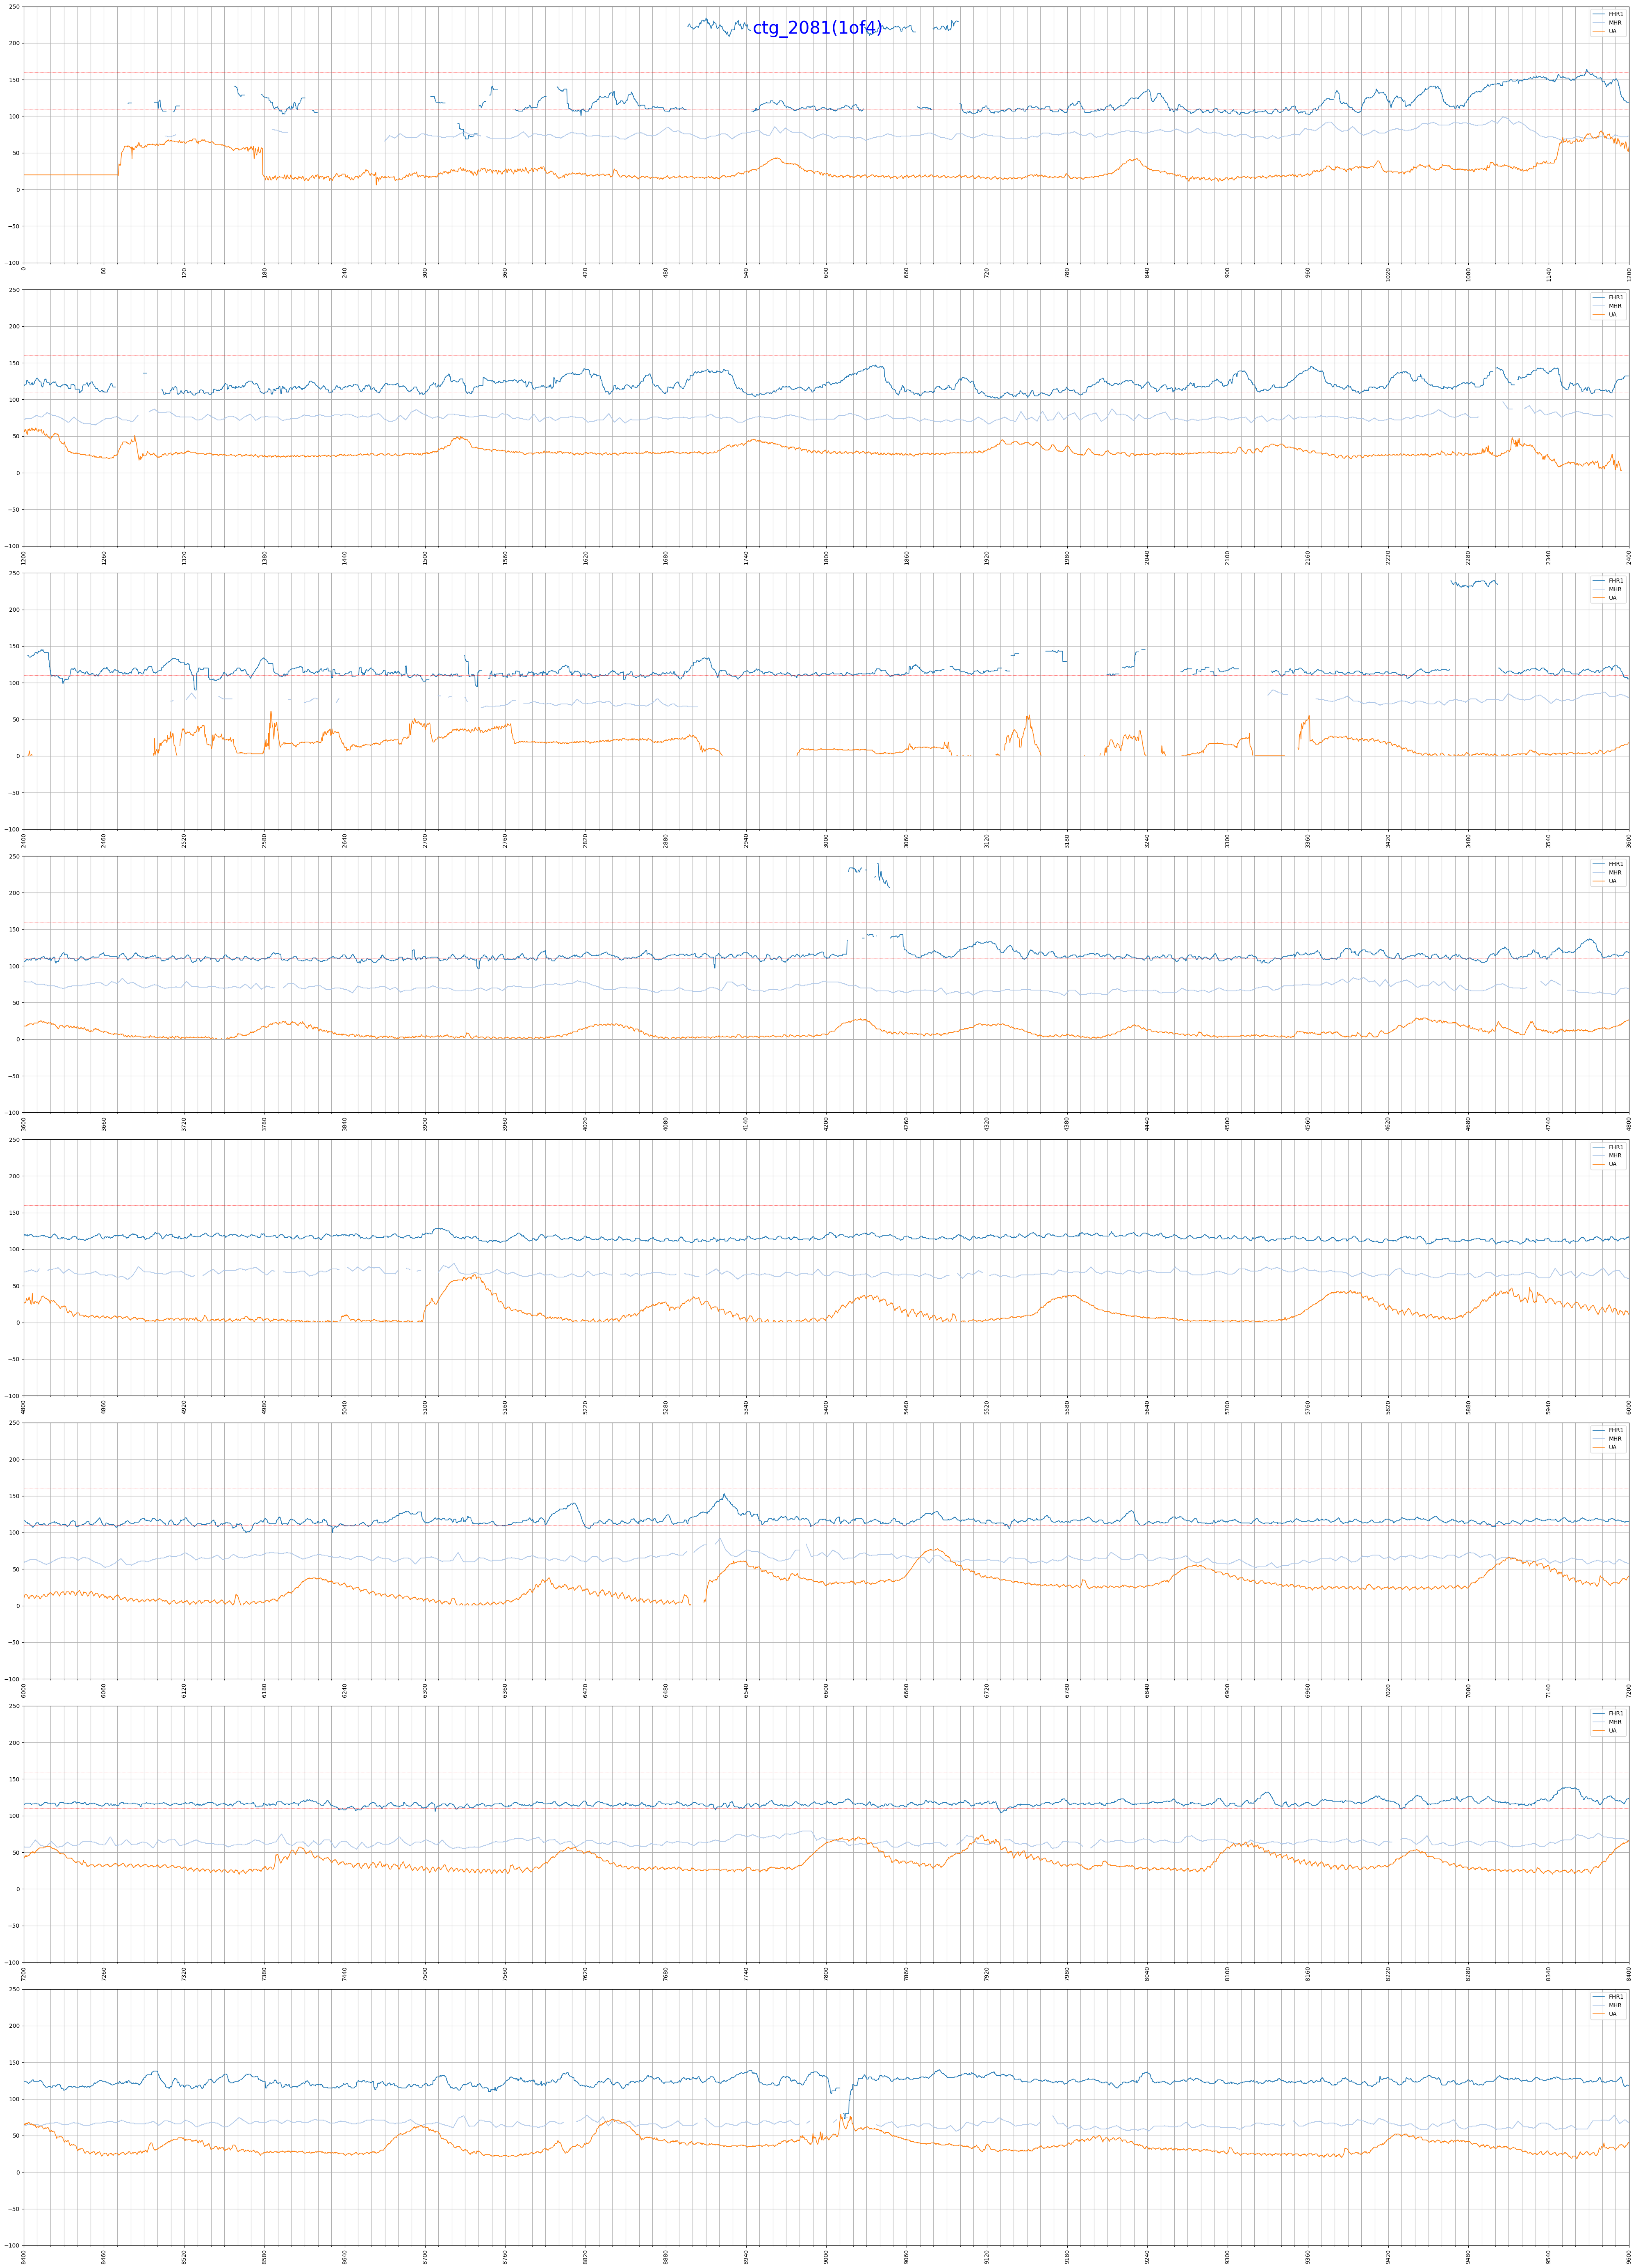

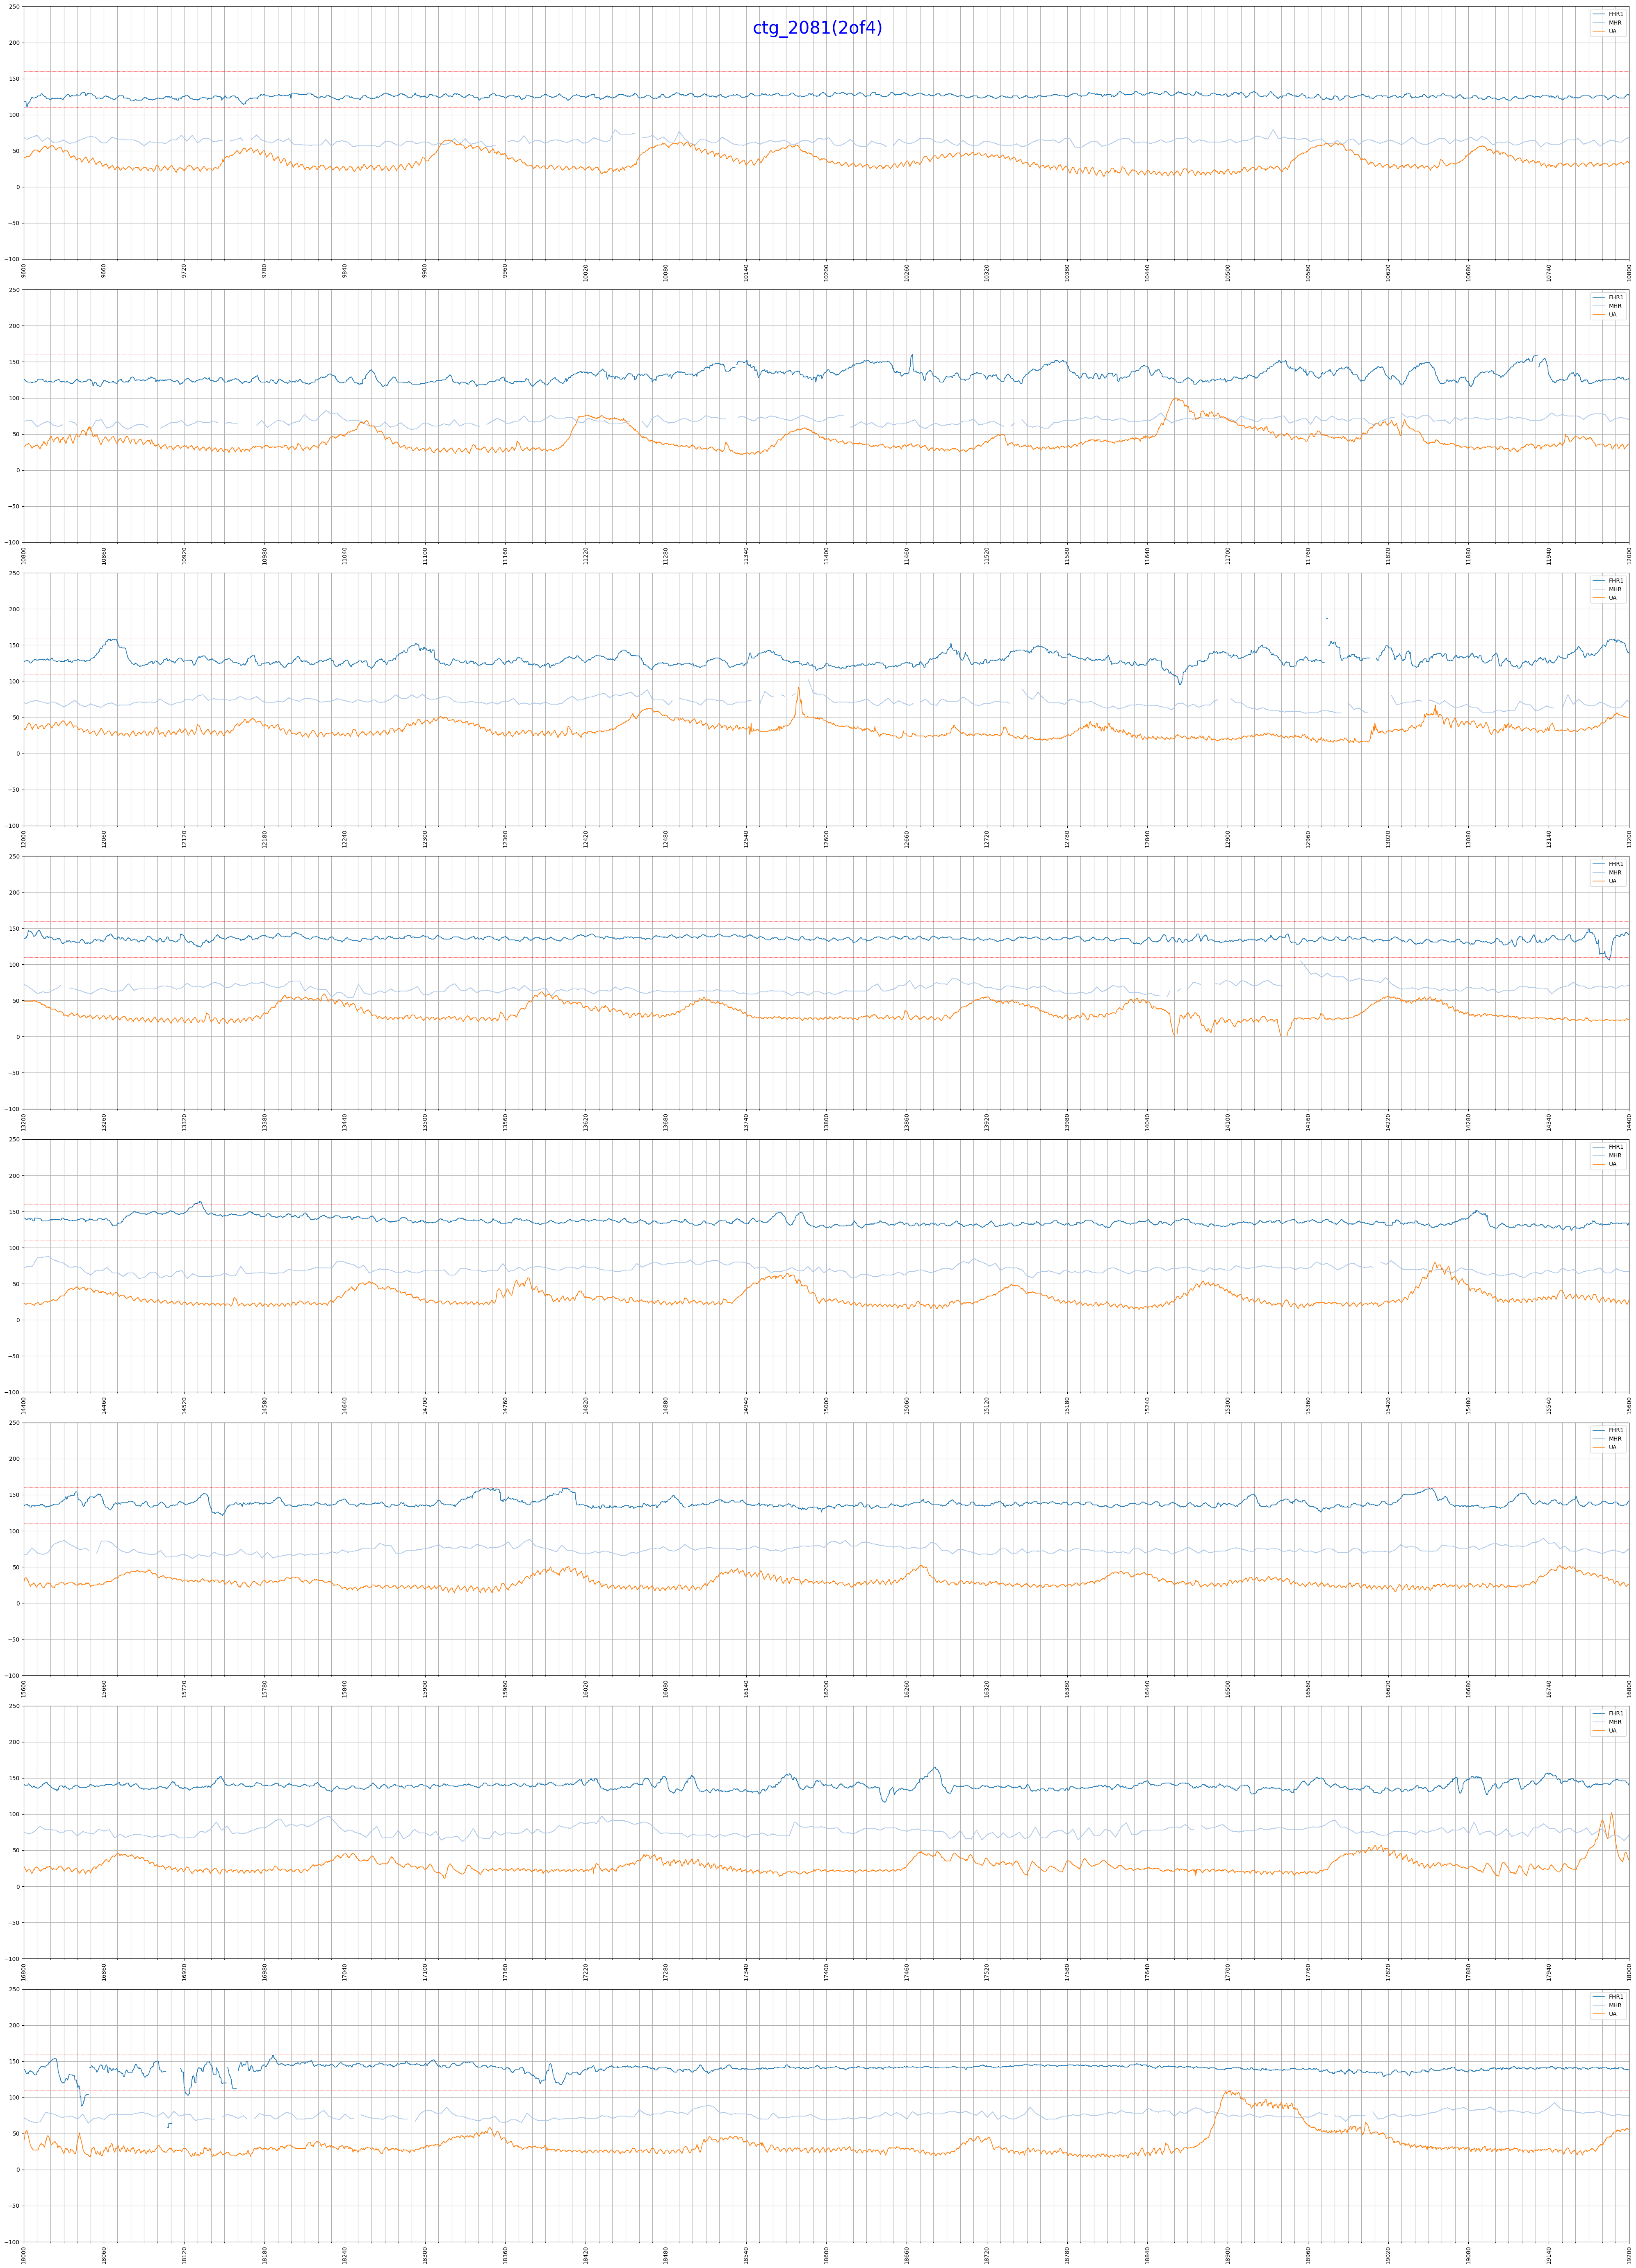

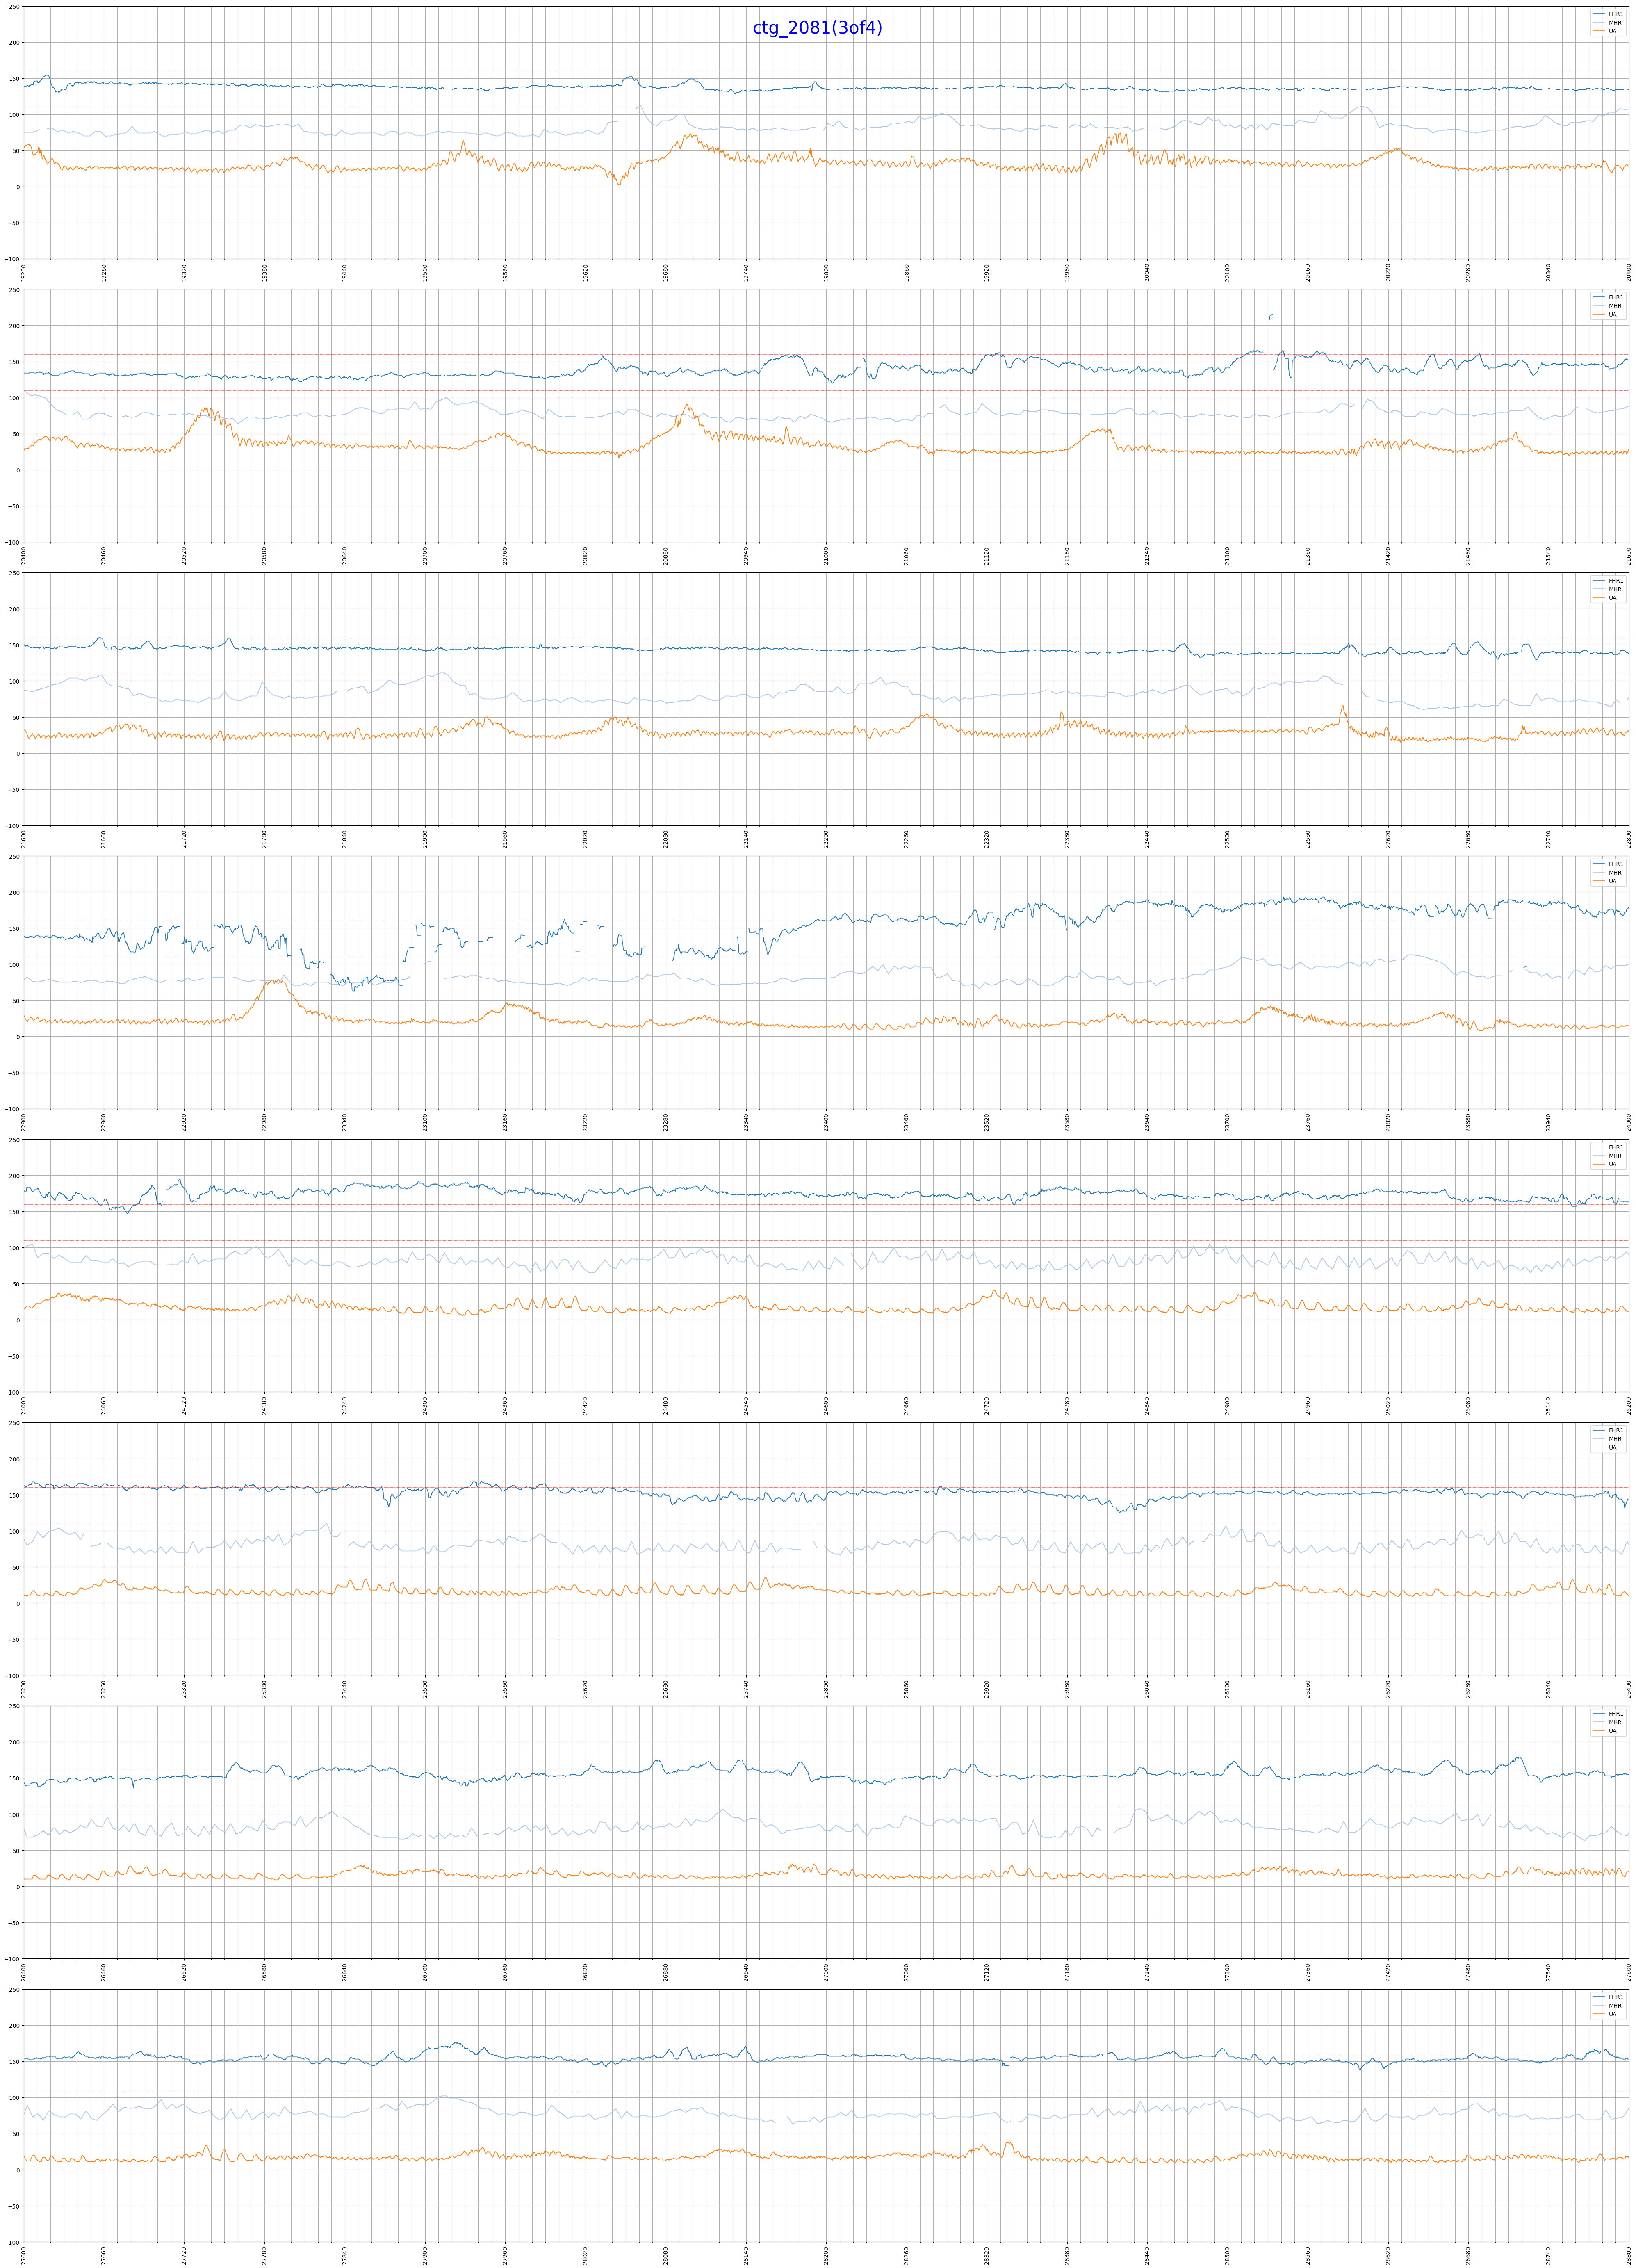

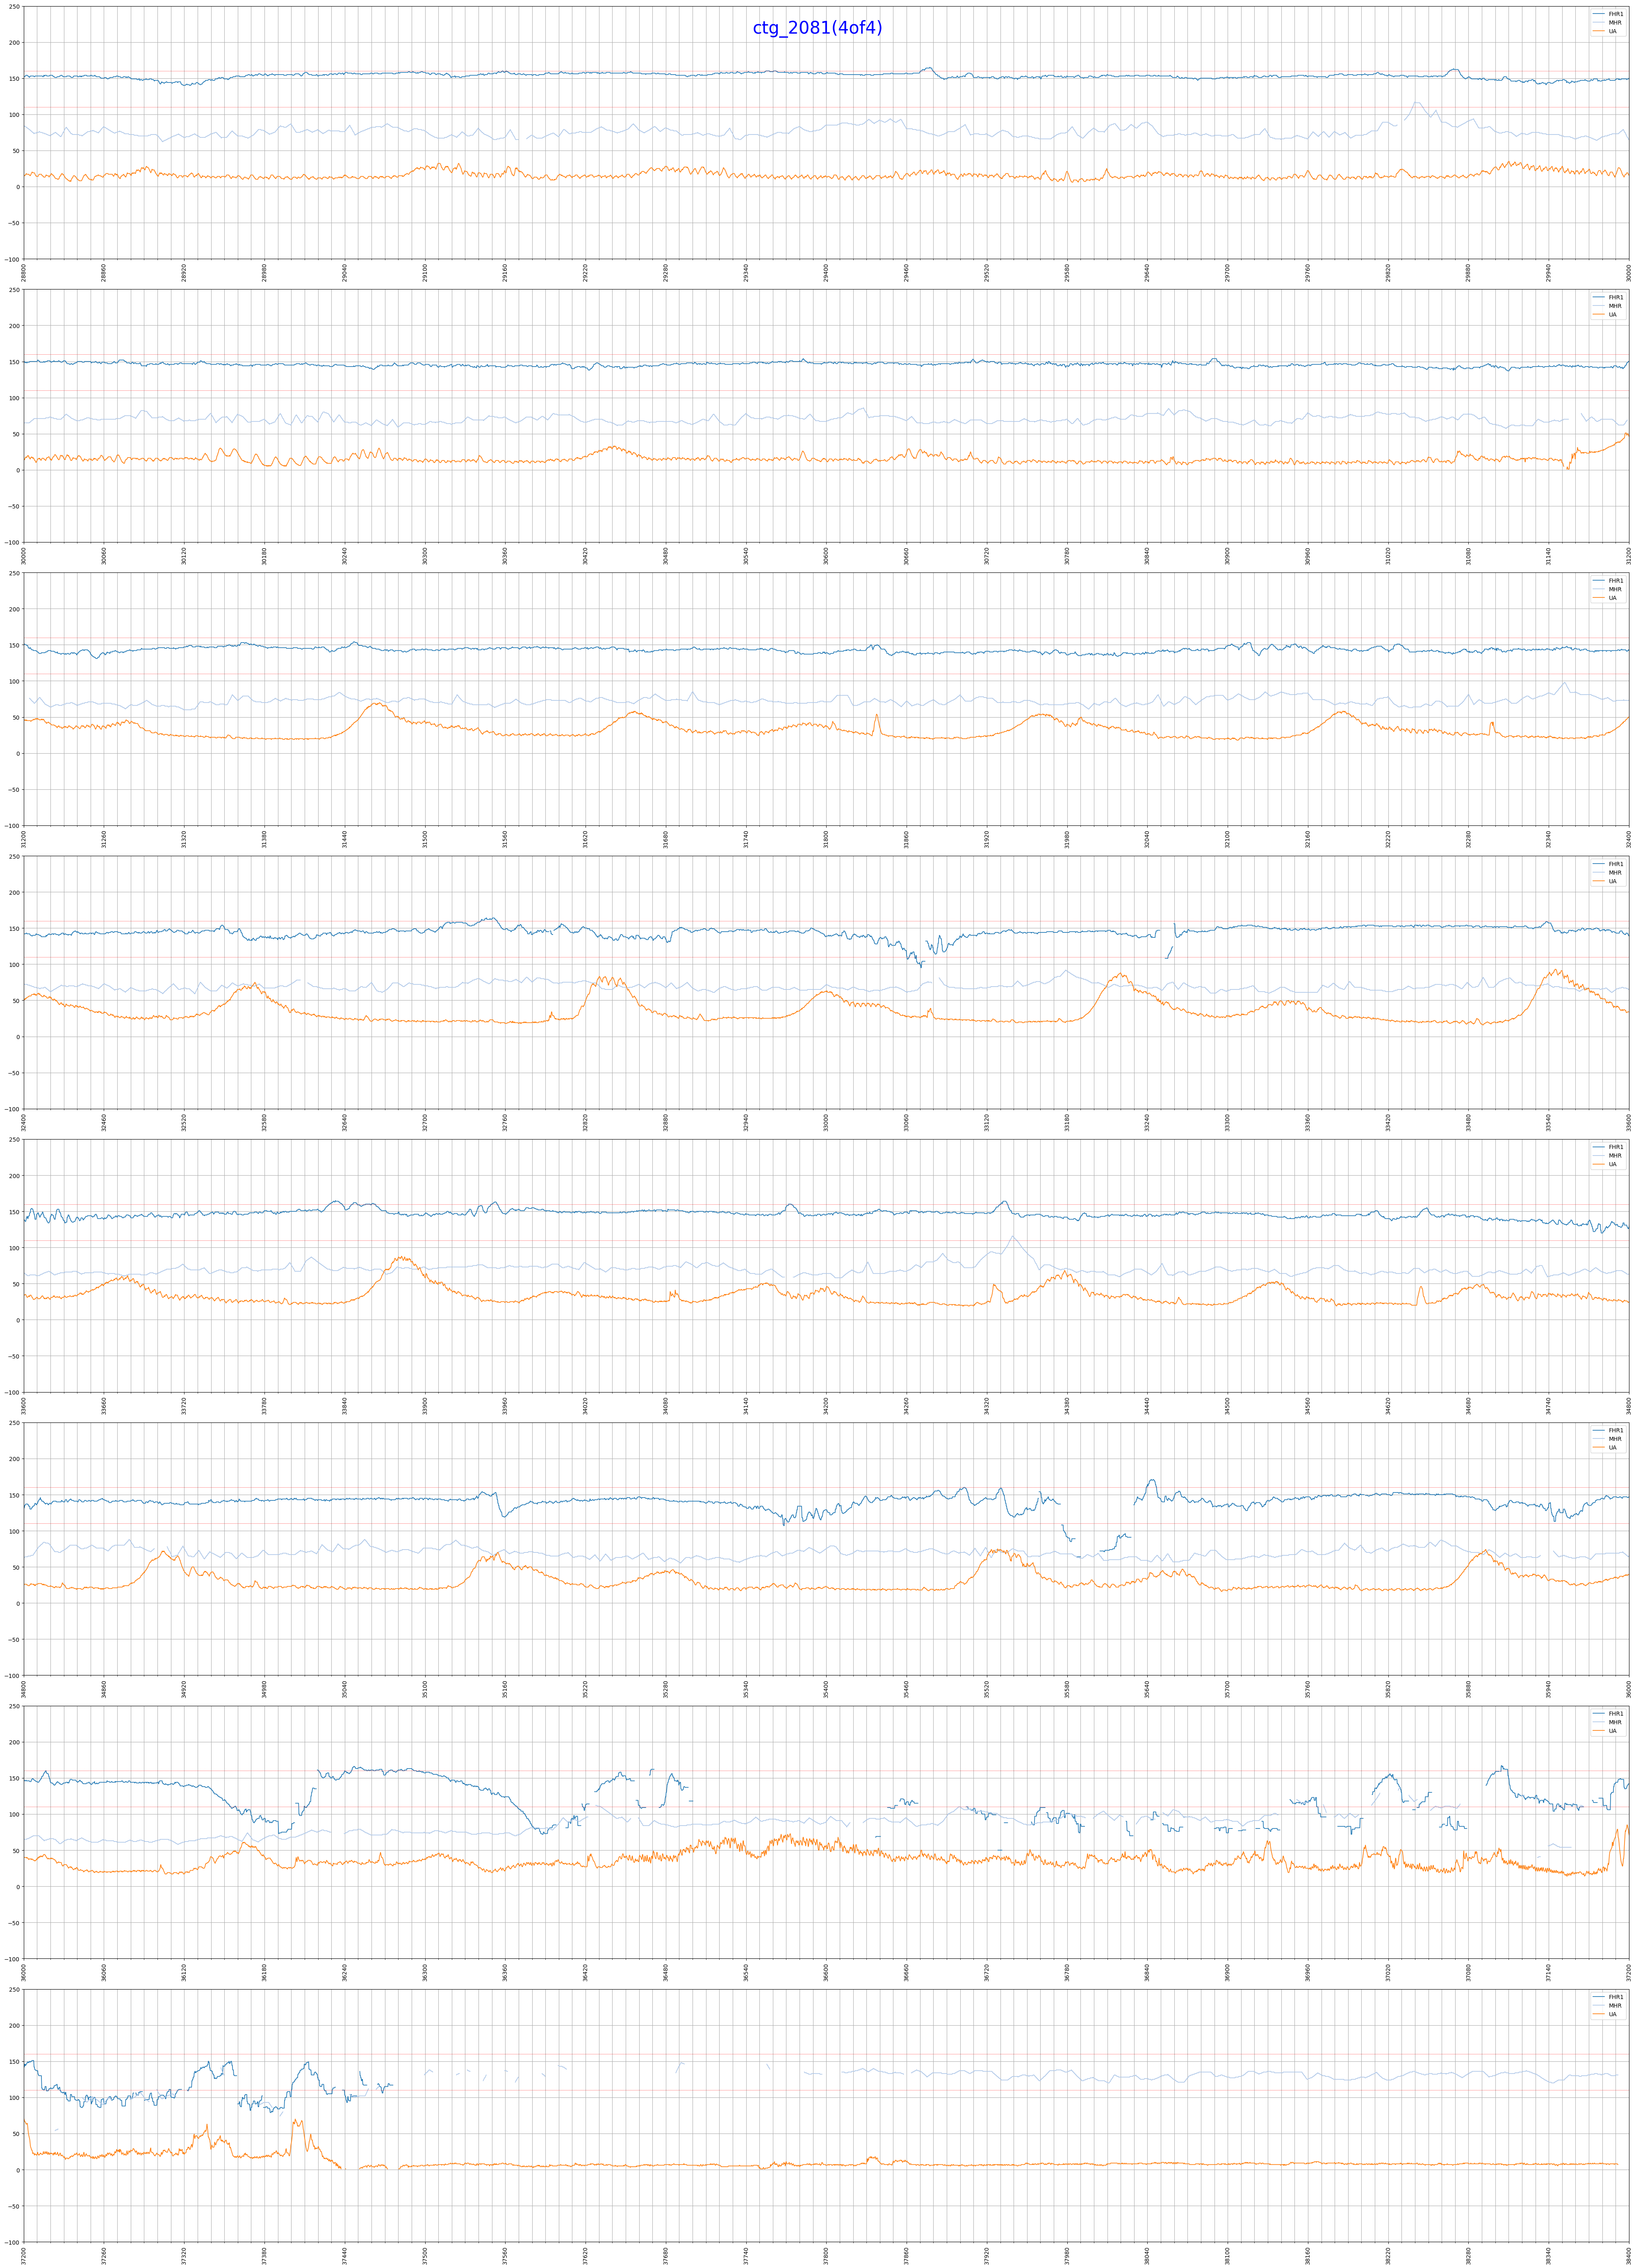

In [ ]:
#Simple Plotter
filename = 'ctg_2081'

df = pd.read_csv(f'/content/drive/MyDrive/2023_04/{filename}.csv')
info = pd.read_csv(f'/content/drive/MyDrive/2023_04/info_{filename}.csv')

lbl_lst = [
    'FHR1',
    'MHR',
    'UA',
]

ROWS_OF_PAGE = 8

fig_id = filename
freq = get_sampling_freq(info.iloc[0].to_dict(), df)
x_width_one = 1200 * freq

data_len = max(len(df.index), x_width_one * 2)  # data length
fig_all_rows = (data_len + x_width_one - 1) // x_width_one

pages = -(-fig_all_rows // ROWS_OF_PAGE)

for p in range(pages):
    (p_from, p_to) = (p * ROWS_OF_PAGE, min((p + 1) * ROWS_OF_PAGE, fig_all_rows))

    if p_from + 1 == p_to:
        p_to += 1  # 1行になるとエラーになるので。
    if pages == 1:
        fig_filename = "{}".format(fig_id)
    else:
        fig_filename = "{}({}of{})".format(fig_id, str(p + 1), pages)
    
    fig_rows = p_to - p_from
    fig_height = 7 * fig_rows
    x_max = x_width_one * fig_rows
    x_max_width = x_max // freq
    x_width = x_max_width // fig_rows

    fig, axes = plt.subplots(fig_rows, 1, figsize=(40, fig_height))
    fig.subplots_adjust(hspace=1.0, wspace=0.4)
    fig.suptitle(fig_filename, size=30, color="blue")
    fig.patch.set_facecolor('white')

    color_list = [
        '#377eb8', '#984ea3', '#ff7f00', '#4daf4a',
        '#a65628', '#e41a1c', 'g', 'b', 'c', 'm',
        '#a65628', '#f781bf', '#f781bf',
    ]

    color_list = color_list * 3
    random.seed(1)

    fhr = df['FHR1'].values
    uc = df['UA'].values

    for i in range(p_from, p_to):
        ii = i - p_from

        for j, lbl in enumerate(lbl_lst):
            axes[ii].plot(
                df[lbl].index / freq,
                df[lbl].values,
                label=lbl,
                color=cm.tab20(
                    j *
                    1 %
                    20
                ),
                lw=1.2
            )
        axes[ii].grid(which='both')
        axes[ii].set_ylim(-100, 250)
        axes[ii].set_xticks(
            np.linspace(
                x_width * i, x_width * (i + 1), 20 + 1
            ), minor=False
        )
        axes[ii].set_xticks(
            np.linspace(
                x_width * i, x_width * (i + 1), 120 + 1
            ), minor=True
        )
        axes[ii].set_xlim(x_width * i, x_width * (i + 1))
        axes[ii].xaxis.set_tick_params(rotation=90)
        axes[ii].axhline(y=160, color='r', ls='--', lw=0.4)
        axes[ii].axhline(y=110, color='r', ls='--', lw=0.4)
        axes[ii].legend()

    plt.tight_layout()
    plt.show()
    plt.close()